# 03 - Classification with Naive Bayes
In this section, we will assess the performance of various Naive Bayes models. In particular, we will examine, in order of complexity:
- Bernoulli Naive Bayes with term presence vectors
- Multinomial Naive Bayes with term frequency vectors
- Multinomial Naive Bayes with [td-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency, inverse document frequency) vectors

[Naive Bayes classifiers](http://sebastianraschka.com/Articles/2014_naive_bayes_1.html) are based off Bayes' theorem of conditional probability, and though they are simple, have performed well particularly for text classification. They are labelled naive because the model assumes conditional independence of features, that is, the presence of a word in a tweet does not affect the probability of other words being observed in the same tweet. Though this assumption does not hold, in practice, the violation of conditional independence does not significantly undermine the accuracy of Naive Bayes in text classification.

In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

pd.options.display.max_colwidth = 400
pd.options.display.max_info_rows = 50
pd.options.display.max_columns = 100
pd.options.display.max_seq_items = 50
%matplotlib inline

### Load data
Because Naive Bayes models classify tweets from their [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) representation, these models do not account for the sequence or semantic meaning of words. Thus, the difference between "swam" and "swimming" is inconsequential to the model, and both words should be represented with the same root of "swim" to prevent an explosion in tweet vector dimensionality. Controlling dimensionality is of special concern given the limited number of tweets in the corpus, and for this reason, stop words, which contribute little to no useful information about the offensiveness of a tweet, should also be ignored. So for classification with Naive Bayes models, we will use lemmatized tweets generated from **02 - Data Wrangling**. 

In [89]:
data_path = os.path.join('..','data','data_all')
with open(data_path, 'rb') as file_in:
    data_all = pkl.load(file_in)
    
df_clean = data_all['df_clean']
df_clean.head(3)
print(df_clean.shape)

(13086, 3)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Bernoulli Naive Bayes with term presence vectors
Given a corpus with a vocabulary of size $v$, each tweet can be represented by a $v$-dimensional vector where each index is associated with a unique term in the vocabulary, a value of 1 indicates the presence of that term in the tweet, and 0 indicates otherwise. Because each tweet is converted to a vector of binary features, a Bernoulli Naive Bayes model can be applied to learn the offensiveness of each tweet.

### Load train and test set

In [94]:
X_train = data_all['X_train']
X_test = data_all['X_test']
y_train = data_all['y_train']
y_test = data_all['y_test']

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9160,)
X_test shape: (3926,)
y_train shape: (9160,)
y_test shape: (3926,)


### Construct and fit pipeline
We build a pipeline consisting of a count vectorizer that converts tweets into binary vectors and the Bernoulli Naive Bayes classifier itself. To optimize the model, we grid search through combinations of hyperparameters:
- **min_df**: A term with a document frequency (the proportion of documents that contain said term) below this threshold is omitted from the vocabulary. This is useful for removing terms that are so rare that they can cause a model to overfit on their infrequent presence.
- **max_df**: A term with a document frequency above this threshold is omitted from the vocabulary. This serves a similar function to removing stop words, but adapts to the contents of a corpus.
- **alpha**: A value for calculating a fail-safe probability in the event of observing an unknown term in the test set.

In [91]:
steps = [('vect', CountVectorizer(binary=True)), ('bnb', BernoulliNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.142, 0.005),
              'bnb__alpha': np.arange(0.0,0.4,0.05)}

pipe_cv_bnb = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_bnb.fit(X_train, y_train)
print('Best parameters:\n', pipe_cv_bnb.best_params_)
print('Best accuracy: ', pipe_cv_bnb.best_score_)

Best parameters:
 {'bnb__alpha': 0.35000000000000003, 'vect__max_df': 0.11000000000000001, 'vect__min_df': 0.0080000000000000002}
Best accuracy:  0.7728165938864628


Optimized hyperparameters produce a Bernoulli Naive Bayes model with a cross-validated accuracy of 0.775. Of particular interest is the surprisingly low max_df hyperparameter, which suggests just removing stop words fell far short of pruning the vocabulary of extraneous terms.

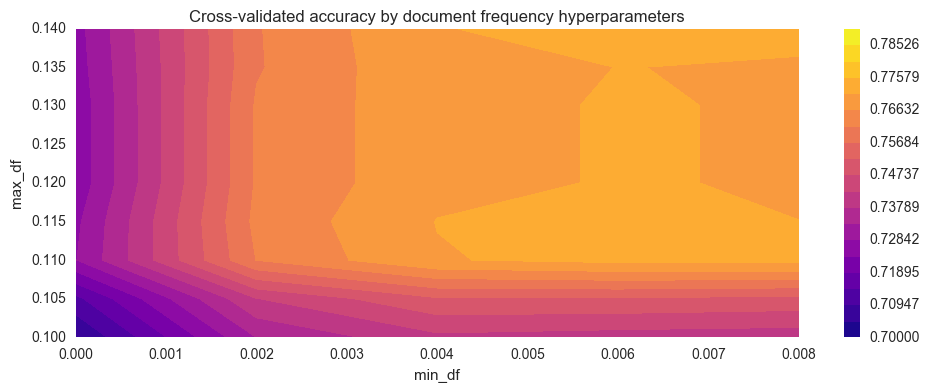

In [92]:
cv_scores = [score[1] for score in pipe_cv_bnb.grid_scores_ if score[0]['bnb__alpha'] == 0.30000000000000004]
min_df = pipe_cv_bnb.param_grid['vect__min_df']
max_df = pipe_cv_bnb.param_grid['vect__max_df']
cv_scores = np.array(cv_scores).reshape(len(max_df), len(min_df))
cv_scores

plt.figure(figsize = (10, 4))
g = plt.contourf(min_df, max_df, cv_scores, cmap = 'plasma', levels = np.linspace(0.7, 0.79, 20))
plt.colorbar(g)
plt.title('Cross-validated accuracy by document frequency hyperparameters')
plt.xlabel('min_df')
plt.ylabel('max_df')
plt.tight_layout()

In fact, the vocabulary used by the model consists of only 186 terms. We can even feed each term back into the model as a one-word tweet and have the model output a probability that the tweet is *not* offensive, allowing us to identify the most and least offensive terms. The list of most offensive terms is largely unsurprising, but the inclusion of "smh" and "wit" is interesting; though not offensive individually, it appears so frequently in offensive tweets that the model considers its presence a strong indicator of offensive speech.

In [95]:
vect = pipe_cv_bnb.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_bnb.best_estimator_.steps[1][1]
probs = estimator.predict_proba(identity)[:,0]

words = sorted(list(vect.vocabulary_.keys()))
words_df = pd.DataFrame(dict(term = words, proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba', ascending = True).head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba', ascending = True).tail(20).T)

Vocabulary size: 186 

MOST OFFENSIVE TERMS
term      bitch    nigga    faggot   niggas    fuckin    nigger      fuck  \
proba  0.001534  0.00187  0.004446  0.00465  0.005212  0.005481  0.016221   

term        ass   fucking      hoe     queer      cunt      shit       gay  \
proba  0.019124  0.027539  0.03275  0.043441  0.047305  0.100356  0.100593   

term        fag     dumb       wit       smh      lame      call  
proba  0.120489  0.16624  0.244827  0.291527  0.330454  0.340162  

LEAST OFFENSIVE TERMS
term      could      good    person     today    change      beat      live  \
proba  0.812298  0.816222  0.818785  0.830133  0.832483  0.832617  0.833465   

term       feel      over     those      last     right      full  christmas  \
proba  0.842271  0.846022  0.858412  0.880262  0.888825  0.892391   0.892561   

term        via     crack       bag       job    blame      book  
proba  0.893456  0.899707  0.900131  0.901971  0.94221  0.945328  


### Model evaluation

Finally, we apply the model on holdout data to test its generalizability to the remainder of the tweets. In addition to accuracy, we are interested in its weighted F1-score, a weighted average of F1-scores for each label that serves as a compromise between [micro-averaging and macro-averaging](http://www.cnts.ua.ac.be/~vincent/pdf/microaverage.pdf) a multi-class F1-score. We also calculate normalized confusion matrices so that the matrices for the training data and test data are comparable.

In [96]:
def evaluate(y, y_pred):
    print('Accuracy:', accuracy_score(y, y_pred))
    print('F1 weighted: ', f1_score(y, y_pred, average = 'weighted'))
    
    matrix = confusion_matrix(y, y_pred)
    matrix = matrix / matrix.sum().sum()
    print('Normalized confusion matrix:\n', matrix)
    
    y_values = y.value_counts()
    y_values = y_values / y_values.sum()
    print('Actual proportions:\n', np.array(y_values))

In [97]:
y_train_pred_bnb = pipe_cv_bnb.predict(X_train)
y_test_pred_bnb = pipe_cv_bnb.predict(X_test)

As expected, the performance of the model on the test data is slightly worse than that of the training data. Where the model tends to struggle significantly is in distinguishing between offensive and hate speech. In fact, the majority of tweets labelled hate speech are mis-classified.

In [98]:
evaluate(y_train, y_train_pred_bnb)

Accuracy: 0.784170305677
F1 weighted:  0.772825555738
Normalized confusion matrix:
 [[ 0.49465066  0.01921397  0.00174672]
 [ 0.055131    0.22882096  0.0470524 ]
 [ 0.02565502  0.06703057  0.06069869]]
Actual proportions:
 [ 0.51561135  0.33100437  0.15338428]


In [102]:
evaluate(y_test, y_test_pred_bnb)

Accuracy: 0.775089149261
F1 weighted:  0.763416316184
Normalized confusion matrix:
 [[ 0.49108507  0.02215996  0.00229241]
 [ 0.05527254  0.22694855  0.04865003]
 [ 0.02445237  0.07208355  0.05705553]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Two-class performance evaluation
That the line between offensive and hateful speech is fuzzy even for humans begs the question of how the model would perform if the distinction is removed and hateful speech is considered offensive. In this case, the model's accuracy on the test data would have been an impressive 89.6%, with most of the mis-classifications occuring as a result of classifying offensive speech as non-offensive.

In [101]:
y_binary = (y_test == 1) | (y_test == 2)
y_pred_binary_bnb = (y_test_pred_bnb == 1) | (y_test_pred_bnb == 2)
evaluate(y_binary, y_pred_binary_bnb)

Accuracy: 0.895822720326
F1 weighted:  0.895321784569
Normalized confusion matrix:
 [[ 0.49108507  0.02445237]
 [ 0.07972491  0.40473765]]
Actual proportions:
 [ 0.51553744  0.48446256]


### Save model for later analysis

In [103]:
with open('../data/model_bnb', 'wb') as file_out:
    pkl.dump(pipe_cv_bnb, file_out)

# Multinomial Naive Bayes with term frequency vectors
In a Bernoulli Naive Bayes model, because each vector element only indicates the presence of a particular term, the model does not account for the multiplicity of terms within a tweet. That is, whether a term occurs just once within a tweet or multiple times makes no difference to the model. By changing the vector representation to a term frequency vector and, by necessity, using a Multinomial Naive Bayes classifier, we can incorporate additional information about each tweet.

In [104]:
steps = [('vect', CountVectorizer()),('mnb', MultinomialNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.145, 0.002),
              'mnb__alpha': np.arange(0.0,0.5,0.1)}

pipe_cv_mnb = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_mnb.fit(X_train, y_train)

print('Best parameters:\n', pipe_cv_mnb.best_params_)
print('Best accuracy: ', pipe_cv_mnb.best_score_)

Best parameters:
 {'vect__max_df': 0.11000000000000001, 'mnb__alpha': 0.30000000000000004, 'vect__min_df': 0.0080000000000000002}
Best accuracy:  0.7701965065502183


The grid search for optimized hyperparameters for Multinomial Naive Bayes returns values for mininum and maximum document frequency that further lower the vocabulary size to 187 terms.

In [105]:
vect = pipe_cv_mnb.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_mnb.best_estimator_.steps[1][1]
words = vect.vocabulary_.keys()
probs = pipe_cv_mnb.predict_proba(words)[:,0]

words_df = pd.DataFrame(dict(term = list(words), proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').tail(20).T)

Vocabulary size: 186 

MOST OFFENSIVE TERMS
term     bitch     nigga    niggas    fuckin    faggot    nigger       ass  \
proba  0.00076  0.000925  0.002351  0.002614  0.003718  0.004089  0.011363   

term       fuck       hoe   fucking      cunt     queer       gay      shit  \
proba  0.011948  0.016136  0.017014  0.026887  0.027152  0.060503  0.061516   

term       fag     dumb       wit       smh     lame      call  
proba  0.07746  0.10778  0.141106  0.195608  0.20025  0.234108  

LEAST OFFENSIVE TERMS
term       find      live    person     today      feel    follow      beat  \
proba  0.731569  0.734283  0.737013  0.740113  0.743364  0.744253  0.744725   

term       over    change     those      last  christmas     right      full  \
proba  0.754975  0.766737  0.787551  0.810497   0.820322  0.821312  0.827789   

term      crack       bag       job       via     blame      book  
proba  0.830769  0.841366  0.844224  0.846469  0.890765  0.919194  


In [106]:
y_train_pred_mnb = pipe_cv_mnb.predict(X_train)
y_test_pred_mnb = pipe_cv_mnb.predict(X_test)

Surprisingly, incorporating additional information about the multiplicity of each term does not improve the model. In fact, Multinomial Naive Bayes performs slightly worse on the training and the test data than its binomial variant. In particular, MNB tends to mis-classify hate speech as offensive and offensive speech as non-offensive more frequently than BNB.

In [107]:
evaluate(y_train, y_train_pred_mnb)

Accuracy: 0.780240174672
F1 weighted:  0.766484780803
Normalized confusion matrix:
 [[ 0.49137555  0.02248908  0.00174672]
 [ 0.05633188  0.23548035  0.03919214]
 [ 0.02510917  0.07489083  0.05338428]]
Actual proportions:
 [ 0.51561135  0.33100437  0.15338428]


In [108]:
evaluate(y_test, y_test_pred_mnb)

Accuracy: 0.769740193581
F1 weighted:  0.756546992249
Normalized confusion matrix:
 [[ 0.48726439  0.02547122  0.00280183]
 [ 0.05731024  0.23025981  0.04330107]
 [ 0.02445237  0.07692308  0.052216  ]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Two-class performance evaluation

In [109]:
y_pred_binary_mnb = (y_test_pred_mnb == 1) | (y_test_pred_mnb == 2)
evaluate(y_binary, y_pred_binary_mnb)

Accuracy: 0.889964340295
F1 weighted:  0.88946302945
Normalized confusion matrix:
 [[ 0.48726439  0.02827305]
 [ 0.08176261  0.40269995]]
Actual proportions:
 [ 0.51553744  0.48446256]


### What are these edge cases?
Below we example those tweets which BNB correctly classified as offensive where MNB failed to do so as well as offensive tweets correctly classified by both BNB and MNB. The misclassified tweets indeed have fewer offensive words than those correctly classified. In fact, some of the correctly classified tweets have offensive words with multiplicity greater than 1. It would seem that using MNB, by incorprating multiplicity into its model, ends up setting a higher threshold for classifying a tweet as offensive that ultimately harms its performance slightly.

In [110]:
df_orig = data_all['df_orig']

Mis-classified offensive tweets

In [111]:
df_test = df_orig.reindex(y_test.index)
df_misclf = df_test[(y_test_pred_bnb == 1) & (y_test_pred_mnb == 0) & (y_test == 1)]
df_misclf.sample(10)

,text,rating,confidence
id,,,
853727097,Would've done more than just thrown a fucking phone on the road...\nLeave them alone.\nEspecially since they're angry already.,1,1.0000
853723195,@iDreamOfCece because those guys know the power of the dollar. We don't make it any better applauding coon shit and giving it shine,1,0.6598
853725079,"@SamoanKing11 35 and finger banging 19yo's in the park smh, I like a couple of his songs but him as a person makes it hard lol",1,0.6615
853729432,only I could get fined ���50 for dropping a fag but on the floor�_��__̫�̩_̫̍_,1,0.6656
853722255,I always fuck things up and by things I mean my relationships with people but this doesn't make me a bad person. Or it kinda does Idk,1,0.6633
853719689,"""...so don't approach me with static. I let it fly like showing Kobe the basket! Bastard! You can quote me on that shit!""",1,1.0000
853726476,As I stood outside McDonalds tryin and failing to make a smokable rollie some kind soul of pbc handed me a box of fags and left..thank u sir,1,1.0000
853729401,@16_Counter_Jace happy birthday big dog. Your still a fag. But I love you. _̫�Љۡ hope it's a good one!,1,1.0000
853723574,@mistergraceffa @JoeyGraceffa I think u met fag but shut up. He's an amazing person. If he loves a guy then he loves a guy big deal. Fucku!,1,1.0000


Correctly classified offensive tweets

In [112]:
df_test = df_orig.reindex(y_test.index)
df_correct = df_test[(y_test_pred_bnb == 1) & (y_test_pred_mnb == 1) & (y_test == 1)]
df_correct.sample(10)

,text,rating,confidence
id,,,
853719478,Dem philly niggas b so great at that dressing them some fly niggas they make everything they put on look great _�㢉�_�_�㢉�_�_�㢉�_�_�㢉�_�_�㢉�_�_�㢉�_�,1,1.0000
853720982,I love being forced into a coowned Twitter account about fave queers that I'll have to remember to keep up thanks @brianissolame,1,0.6667
853726196,"Just cause I got girl besties &amp; don't be all up on u niggas like a Thot , I'm considered a lebian ? _̫�_��_ how do y'all sound _̫��̍_̫_�_̫�_",1,1.0000
853728828,@ZlNTAX you fag,1,1.0000
853723610,lmaoo and your receiver still can't find out what a catch is. #wedemdropboyz lol he's a fag but you fuck with greg? https://t.co/RSIu3KX73V,1,0.6636
853731138,"If she know all the lyrics to ""Got An Ass So Big Like The Sun"" , I'm so sorry y'all, but she shone _̫�Љۡ_̫�Љۡ_̫�Љۡ",1,1.0000
853722664,"she probably giving some road head rn to some lame ass white boy, but that's alright i ain't see it happen man so it didn't happen.",1,0.6735
853726951,How U gonna say Nigga and than say sand nigger?? Lmaoo https://t.co/AYdlmve3PU,1,1.0000
853719673,'will u get with me' 'I don't want a boyfriend haha sorry' 'oh fuck ya then' hahahahaha poor little bastard_�㢉�_�__�㢉�_�__�㢉�_�_,1,1.0000


# Multinomial Naive Bayes with TF-IDF

The TF-IDF model takes the term frequency model a few extra steps. First, whereas previously a term frequency vector consisted of integers representing the multiplicities of terms within a tweet, TF-IDF normalizes these values by dividing each vector element by the number of words in the tweet. Thus, additional information about the length of a tweet is incorporated into the model. The IDF part of the model, inverse document frequency, weights each element of the vector, penalizing terms that appear too frequently in other tweets and boosting rarer terms.

Theoretically, such a weighting of vector elements could obviate the need to exclude stop words or set min and max document frequency hyperparameters, but it turns out such parameters are still necessary to tuning an optimal model. In fact, the parameters found through grid search on MNB with TFIDF are the same as those found for a regular count vectorizer.

In [113]:
steps = [('vect', TfidfVectorizer()),('mnb', MultinomialNB())]
pipe = Pipeline(steps)

parameters = {'vect__min_df': np.arange(0,0.010, 0.002),
              'vect__max_df': np.arange(.10,.145, 0.002),
              'mnb__alpha': np.arange(0.0,0.5,0.1)}

pipe_cv_tfidf = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'accuracy')
pipe_cv_tfidf.fit(X_train, y_train)

print('Best parameters:\n', pipe_cv_tfidf.best_params_)
print('Best accuracy: ', pipe_cv_tfidf.best_score_)

Best parameters:
 {'vect__max_df': 0.11200000000000002, 'mnb__alpha': 0.0, 'vect__min_df': 0.0040000000000000001}
Best accuracy:  0.762882096069869


In [114]:
vect = pipe_cv_tfidf.best_estimator_.steps[0][1]
vocab_size = len(vect.vocabulary_)
print('Vocabulary size:', vocab_size,'\n')
identity = np.eye(vocab_size)

estimator = pipe_cv_tfidf.best_estimator_.steps[1][1]
words = vect.vocabulary_.keys()
probs = pipe_cv_tfidf.predict_proba(words)[:,0]

words_df = pd.DataFrame(dict(term = list(words), proba = probs))
words_df = words_df[['term', 'proba']].set_index('term')

print('MOST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').head(20).T)
print()
print('LEAST OFFENSIVE TERMS')
print(words_df.sort_values(by = 'proba').tail(20).T)

Vocabulary size: 369 

MOST OFFENSIVE TERMS
term   bitch  niggas  nigga  fuckin    faggot    nigger       ass      fuck  \
proba    0.0     0.0    0.0     0.0  0.003294  0.003427  0.009154  0.010739   

term      cunt     queer       hoe   fucking    cuffin     pussy       gay  \
proba  0.01852  0.018892  0.020362  0.021237  0.029159  0.034617  0.041933   

term       shit      shut       fag   bastard     outta  
proba  0.058709  0.062355  0.064146  0.083782  0.084875  

LEAST OFFENSIVE TERMS
term        job     cover      high   holiday   control    under      gift  \
proba  0.848314  0.849124  0.855676  0.860666  0.867217  0.87013  0.871395   

term        via     blame     force      rule  religion      news   married  \
proba  0.874282  0.875083  0.883507  0.887818   0.89568  0.899418  0.917389   

term       book    equal       tie  usually  ultimate   version  
proba  0.937049  0.96258  0.963111   0.9662  0.968377  0.968981  


In [115]:
y_train_pred_tfidf = pipe_cv_tfidf.predict(X_train)
y_test_pred_tfidf = pipe_cv_tfidf.predict(X_test)

In yet another surprise, the performance of MNB using the more sophisticated TFIDF model is worse still than the simplier term frequency model and the even simplier BNB model. It may be that tweets are fundamentally too short and the dataset too small for the application of more complex models. Additionally, the nature of the classification problem, whether or not a tweet is offensive, hinges only on the presence of a small set of terms when modelling each tweet as a bag of words. As such, incorporating multiplicity and IDF contributes too little useful information to offset the cost of modeling with greater complexity.

In [116]:
evaluate(y_train, y_train_pred_tfidf)

Accuracy: 0.778820960699
F1 weighted:  0.748497375841
Normalized confusion matrix:
 [[ 0.49421397  0.02008734  0.00131004]
 [ 0.06124454  0.25665939  0.01310044]
 [ 0.02740175  0.09803493  0.0279476 ]]
Actual proportions:
 [ 0.51561135  0.33100437  0.15338428]


In [117]:
evaluate(y_test, y_test_pred_tfidf)

Accuracy: 0.759042282221
F1 weighted:  0.727177081774
Normalized confusion matrix:
 [[ 0.48828324  0.02547122  0.00178299]
 [ 0.06622517  0.24758023  0.01706572]
 [ 0.02445237  0.10596026  0.02317881]]
Actual proportions:
 [ 0.51553744  0.33087112  0.15359144]


### Two-class performance evaluation

In [118]:
y_pred_binary_tfidf = (y_test_pred_tfidf == 1) | (y_test_pred_tfidf == 2)
evaluate(y_binary, y_pred_binary_tfidf)

Accuracy: 0.882068262863
F1 weighted:  0.881355083129
Normalized confusion matrix:
 [[ 0.48828324  0.0272542 ]
 [ 0.09067753  0.39378502]]
Actual proportions:
 [ 0.51553744  0.48446256]


# Tweet rater
Finally, below is a simple function that uses the BNB model to rate new user-generated tweets.

In [119]:
import re
import spacy

nlp = spacy.load('en')

def replace_user(tweet):
    return re.sub(r'(@\w+\s*)', r'<user> ', tweet)

def replace_url(tweet):
    return re.sub(r'(https?://\S*)', r'<url> )', tweet)

def erase_special(tweet):
    regex = r'#|&|\(|\)|\"|\.|\?|!|,|;|:|(�\S*\d*)|(_*UNDEF)|\\n|\s\'|\'\s|-|/|$|%|\n|{|}|[|]|~'
    return re.sub(regex, ' ', tweet)

def erase_numbers(tweet):
    regex = r'(128\d{3})|(82\d{2})'
    return re.sub(regex, ' ', tweet)

def normalize(tweet):
    x = tweet.split()
    y = ''
    for token in x:
        y = ' '.join([y,token.lower()])
    return y[1:]

def clean_tweet(tweet):
    tweet = replace_user(tweet)
    tweet = replace_url(tweet)
    tweet = erase_numbers(tweet)
    tweet = erase_special(tweet)
    return tweet

def lemmatize(tweet):
    x = str()
    for token in nlp(tweet):
        if token.text in ['user','url','<','>']:
            continue
        else:
            x = ' '.join([x, token.lemma_])
    return x[1:]

def remove_stop(tweet):
    x = str()
    for token in nlp(tweet):
        if token.text == '-PRON-':
            continue
        if token.is_stop:
            continue
        else:
            x = ' '.join([x, token.text])
    return x[1:]

In [120]:
def tweet_rater(tweet, clf):
    tweet = clean_tweet(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_stop(tweet)
    
    print(tweet)
    rating = clf.predict([tweet])
    probability = clf.predict_proba([tweet])
    print(probability)
    if rating == 0:
        print('I\'m {:2.4}% sure that\'s not offensive.'.format(probability[0][0]*100))
    elif rating == 1:
        print('I\'m {:2.4}% sure that\'s offensive.'.format(probability[0][1]*100))
    else:
        print('I\'m {:2.4}% sure that\'s hate speech.'.format(probability[0][2]*100))

In [121]:
tweet_rater('i hate you all', pipe_cv_bnb)

hate
[[ 0.36362291  0.27177805  0.36459903]]
I'm 36.46% sure that's hate speech.
